# Planaria single-cell

In [7]:
import numpy as np
import pandas as pd
import networkx as nx
import pyemb as eb
import matplotlib.pyplot as plt

## Load data

This section uses [data](https://shiny.mdc-berlin.de/psca/) from the paper ['Cell Type Atlas and Lineage Tree of a Whole Complex Animal by Single-Cell Transcriptomics'](https://www.science.org/doi/abs/10.1126/science.aaq1723). It contains expression levels of $p= 5821$ genes measured across $n=5000$ individual cells from adult planarians, a type of flatworm. Such data offer the possibility of discovering the cell lineage tree of an entire animal: the
aim is to find out if the data reflect the tree-structured process by which stem cells differentiate into a variety of distinct cell types. These data were prepared using the Python package [Scanpy](https://scanpy.readthedocs.io/en/stable/index.html), where the script on how to do this can be found [here](https://nbviewer.org/github/rajewsky-lab/planarian_lineages/blob/master/paga/preprocessing.ipynb).

In [2]:
Y = np.array(pd.read_csv('data/planaria_sample_data.csv', index_col=0))
(n,p) = Y.shape
print('Data matrix is', n, 'samples by', p, 'features')

labels = np.genfromtxt('data/sample_annotation_5000.txt', delimiter=',', dtype=str) 
ordered_cats = np.genfromtxt('data/planaria_ordered_cats.csv', delimiter=',', dtype=str)

colors = pd.read_csv('data/colors_dataset.txt', header=None, sep='\t')
colors = {k: c for k, c in colors.values}

Data matrix is 5000 samples by 5821 features


## Dimension selection and visualisation

Perform dimension selection using Wasserstein distances, as explained in ['Statistical exploration of the Manifold Hypothesis'](https://arxiv.org/pdf/2208.11665).

In [3]:
# ws, dim = eb.wasserstein_dimension_select(Y, range(20), split=0.5)
# print("Selected dimension: {}".format(dim))
dim = 14

Now, perform PCA with the embedding function and visualise. 

In [4]:
zeta = p**-.5 * eb.embed(Y, d=dim, version='full')

In [5]:
## TSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity = 30).fit_transform(zeta)

We can plot the two representations of our data with the `snapshot_plot` function

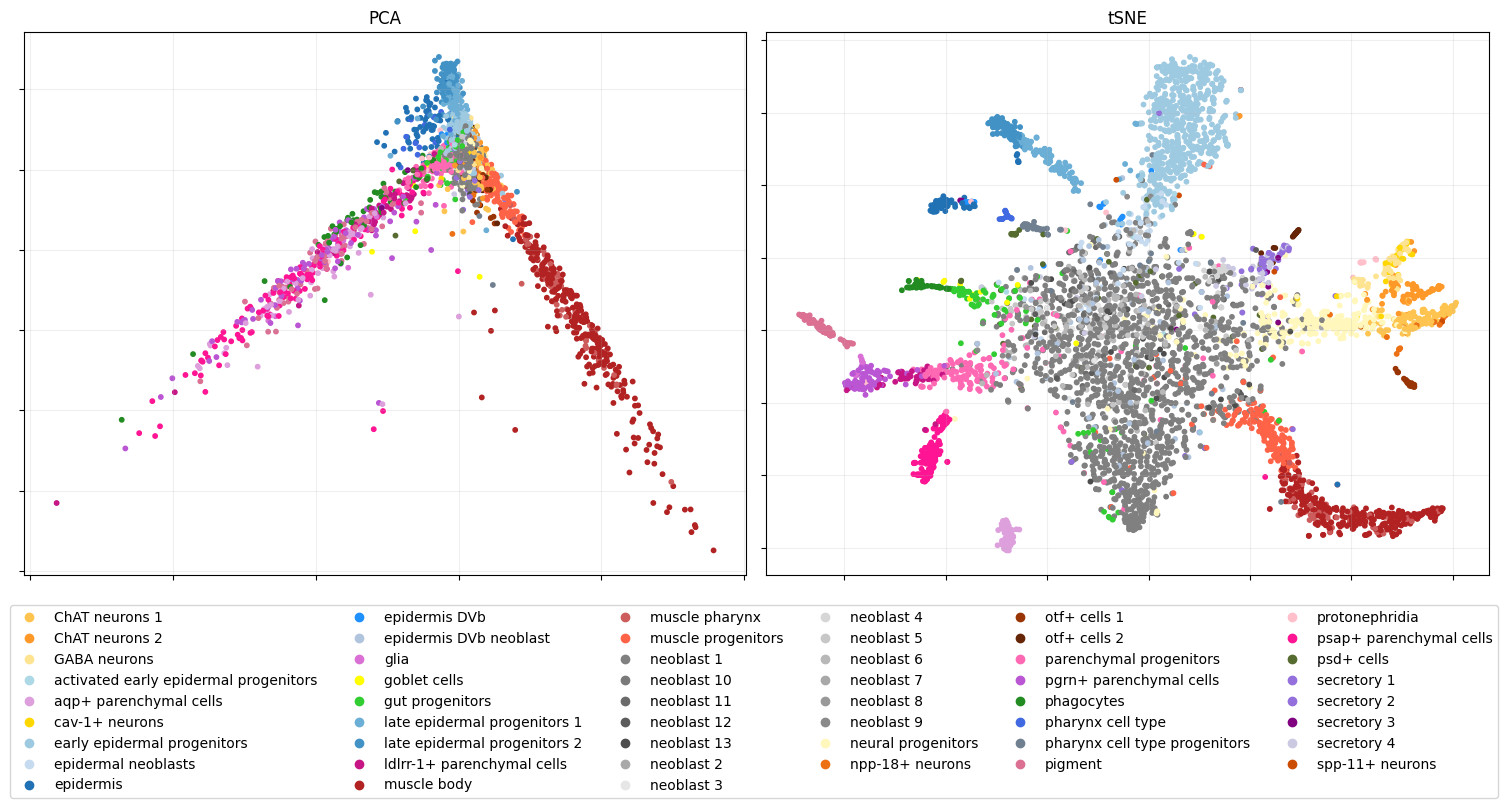

In [8]:
pca_fig = eb.snapshot_plot(
    embedding = [zeta[:,:2],tsne], 
    node_labels = labels.tolist(), 
    c = colors,
    title = ['PCA','tSNE'],
    add_legend=True, 
    max_legend_cols = 6,
   figsize = (15,6),
   bbox_to_anchor= (.5,-.35),
    # Apply other matplotlib settings
    s=10,
)
plt.tight_layout()

## Construct tree

From here we want to perform hierarchical clustering on the data and simplify this tree. This can be done using the hierarchical clustering module. 

We use hierarchical clustering with dot products as descibed in ['Hierarchical clustering with dot products
recovers hidden tree structure'](https://proceedings.neurips.cc/paper_files/paper/2023/file/6521937507d78f327cd402401be73bf2-Paper-Conference.pdf). This is the default HC in the class `ConstructTree` so we can just give it our point cloud. Otherwise, the HC can be done first and the model can be given to the `ConstructTree` class. 

The `epsilon` parameter controls the threshold for condensing tree and if set to zero the full tree will be given. 

In [24]:
tree = eb.ConstructTree(zeta, epsilon=0.25)
tree.fit()

Performing clustering...
Calculating branch lengths...
Constructing tree...


This can then be plotted. Points are coloured by labels, if a plotted node is a collection of data points then `colour_threshold` controls when to colour this node by the majority type of data point (colour by majority if proportion of majority is greater than colour_threshold), else, if there is no majority node, it is plotted black. 

Layouts, node settings and others can also be changed.

100%|██████████| 250/250 [00:02<00:00, 113.01it/s]


BarnesHut Approximation  took  1.21  seconds
Repulsion forces  took  0.81  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


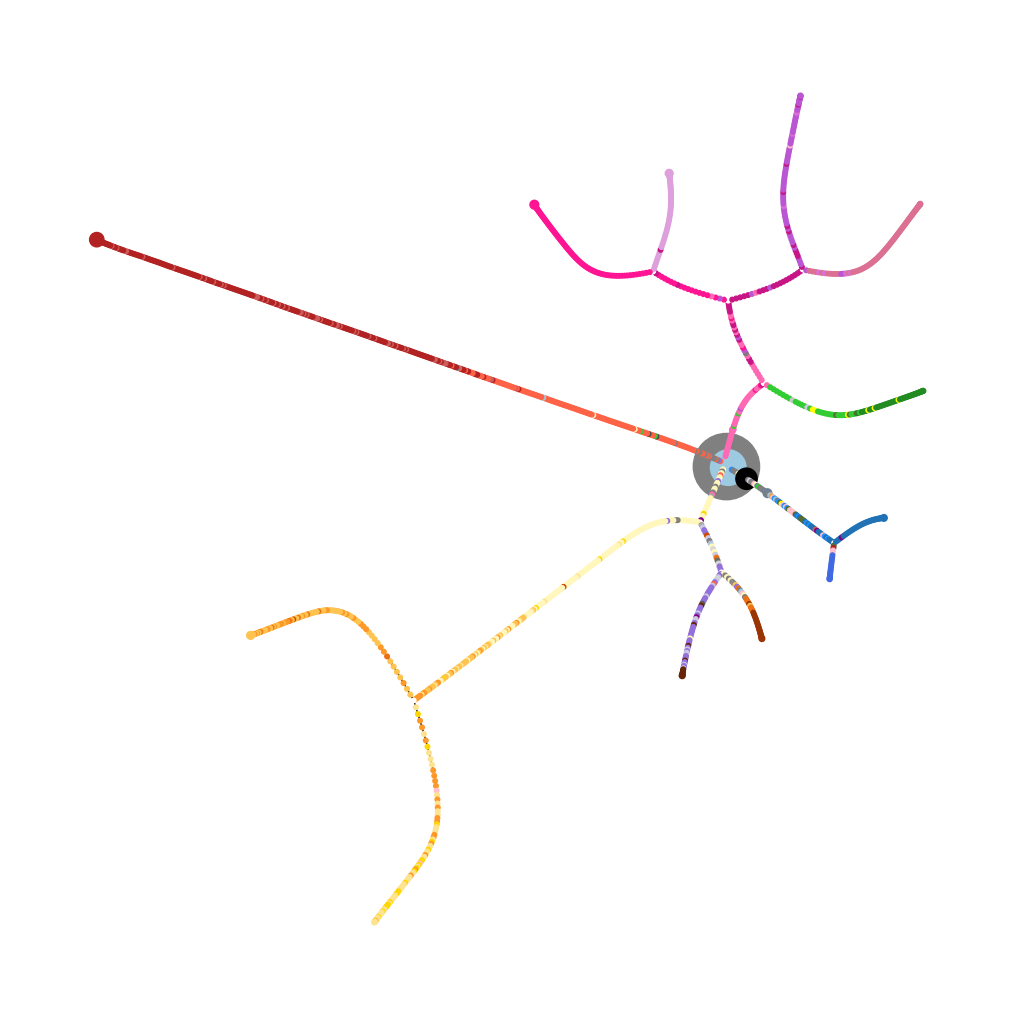

In [25]:
tree.plot(labels,colors, prog = 'twopi')